# Highpass, Lowpass, and Bandpass Filters (One-way vs Two-way, Minimum-phase vs Zero-phase)

This notebook is for a hands-on introduction to filtering in seismology and signal processing.

You will learn:
- What **highpass**, **lowpass**, and **bandpass** filters do
- The difference between **one-way** (causal) filtering and **two-way** (acausal / zero-phase) filtering
- What **minimum-phase** and **zero-phase** mean (and when you might prefer each)
- How filter **order** changes sharpness, ringing, and time-domain artifacts
- How to visualize filters in the **time domain**, **frequency domain**, and via **poles & zeros**
- A short section at the end on **digital vs analog** filters and practical implementation notes

> In the early sections we speak in “analog” terms (continuous-time intuition).  
> In the code, we implement filters digitally (because we’re working with sampled data).



## 0) Setup

We’ll use:
- `numpy` for arrays
- `matplotlib` for plots
- `scipy.signal` for filter design and application

If you don’t have SciPy, install it (in a terminal):
```bash
conda install scipy
# or
pip install scipy
```


In [1]:

import numpy as np
import matplotlib.pyplot as plt

from scipy import signal

# Plot helpers: we won't set specific colors/styles.
def plot_time(t, x, title="", xlabel="Time (s)", ylabel="Amplitude"):
    fig, ax = plt.subplots(figsize=(10, 3))
    ax.plot(t, x)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(True, alpha=0.3)
    plt.show()

def plot_spectrum(x, fs, title="", nfft=None):
    x = np.asarray(x)
    if nfft is None:
        nfft = int(2**np.ceil(np.log2(len(x))))
    X = np.fft.rfft(x, n=nfft)
    f = np.fft.rfftfreq(nfft, d=1/fs)
    mag = np.abs(X)
    fig, ax = plt.subplots(figsize=(10, 3))
    ax.plot(f, mag)
    ax.set_title(title)
    ax.set_xlabel("Frequency (Hz)")
    ax.set_ylabel("|X(f)|")
    ax.set_xlim(0, fs/2)
    ax.grid(True, alpha=0.3)
    plt.show()

def plot_freq_response(sos, fs, title="Frequency response"):
    w, h = signal.sosfreqz(sos, worN=4096, fs=fs)
    fig, ax = plt.subplots(figsize=(10, 3))
    ax.plot(w, 20*np.log10(np.maximum(np.abs(h), 1e-12)))
    ax.set_title(title)
    ax.set_xlabel("Frequency (Hz)")
    ax.set_ylabel("Magnitude (dB)")
    ax.set_xlim(0, fs/2)
    ax.grid(True, alpha=0.3)
    plt.show()

def plot_phase_response(sos, fs, title="Phase response"):
    w, h = signal.sosfreqz(sos, worN=4096, fs=fs)
    phase = np.unwrap(np.angle(h))
    fig, ax = plt.subplots(figsize=(10, 3))
    ax.plot(w, phase)
    ax.set_title(title)
    ax.set_xlabel("Frequency (Hz)")
    ax.set_ylabel("Phase (rad)")
    ax.set_xlim(0, fs/2)
    ax.grid(True, alpha=0.3)
    plt.show()

def plot_pz(z, p, title="Pole-zero plot"):
    fig, ax = plt.subplots(figsize=(5, 5))
    # Unit circle for digital filters
    th = np.linspace(0, 2*np.pi, 800)
    ax.plot(np.cos(th), np.sin(th))
    ax.axhline(0)
    ax.axvline(0)
    if len(z):
        ax.scatter(np.real(z), np.imag(z), facecolors='none', edgecolors='C0', s=60, label='zeros')
    if len(p):
        ax.scatter(np.real(p), np.imag(p), marker='x', color='C1', s=60, label='poles')
    ax.set_aspect('equal', 'box')
    ax.set_title(title)
    ax.set_xlabel("Re{z}")
    ax.set_ylabel("Im{z}")
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)
    ax.legend()
    plt.show()



## 1) Core ideas (analog intuition)

### Lowpass
Passes **low frequencies**, attenuates high frequencies.
- Use for: removing high-frequency noise, smoothing, isolating long-period components (tremor envelope, tilt-like signals, etc.)

### Highpass
Passes **high frequencies**, attenuates low frequencies.
- Use for: removing drifts/offsets, instrument steps, long-period contamination, emphasizing sharp arrivals (P/S)

### Bandpass
Passes a **range** of frequencies.
- Use for: isolating a known band where signal-to-noise is best (e.g., P-wave band, LP band, tremor band)

In analog terms, filters are described by a continuous-time transfer function \(H(s)\) (with \(s=j\omega\)).
In practice, we design digital approximations for sampled data.



## 2) One-way vs two-way filtering (causal vs acausal)

### One-way (causal) filtering
- Implemented with a forward-time recursive filter (e.g., `lfilter` or `sosfilt`)
- **Causal**: output at time \(t\) depends only on input at times \(\le t\)
- Introduces **phase delay** (group delay): waveforms and picks can shift in time

**When you want it:**
- Real-time monitoring
- Picking where you explicitly account for delay (or use phase-preserving designs)
- Anything where causality matters (you can’t use the future)

### Two-way (forward-backward) filtering
- Implemented by filtering forward, then reversing and filtering again (e.g., `filtfilt` / `sosfiltfilt`)
- **Acausal**: uses future samples; not suitable for real-time
- Produces **zero-phase** response (phase cancels), so **arrival times are preserved** (no net phase shift)
- But: it can create **edge transients** and can “ring” symmetrically around sharp features

**When you want it:**
- Offline processing when you care about accurate timing of phases
- Creating clean-looking bandpassed waveforms for analysis/teaching/figures



## 3) Minimum-phase vs zero-phase

### Zero-phase
A filter is “zero-phase” if it has **no phase distortion** (its phase is 0, or linear with zero net delay).
Forward-backward filtering is a common way to achieve **zero-phase** in practice.

### Minimum-phase
A minimum-phase filter is **causal and stable**, with all zeros inside the unit circle (digital case),
and it achieves the **smallest possible group delay** for a given magnitude response.

**Tradeoff intuition:**
- Zero-phase (two-way) is great for preserving arrival times in offline work
- Minimum-phase is great when you need causality but want the **least** delay/distortion possible


## 4) Build a synthetic seismogram and noise

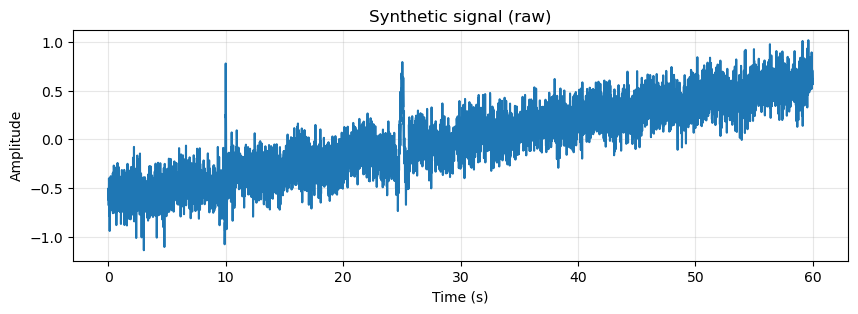

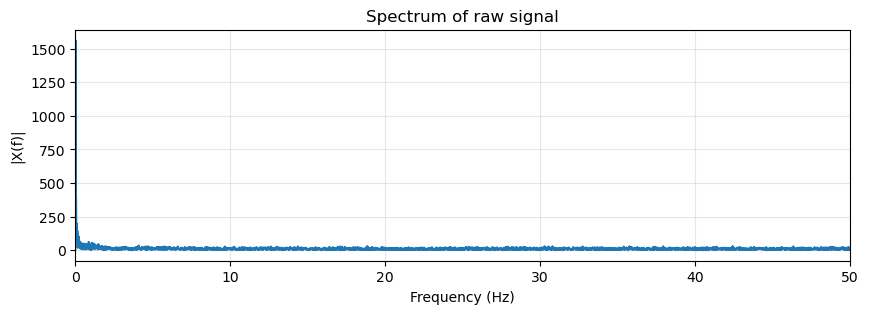

In [2]:

fs = 100.0          # sample rate (Hz)
dt = 1/fs
T = 60.0            # seconds
t = np.arange(0, T, dt)

# A simple synthetic: sharp P-like onset + lower-frequency LP-like wavelet later + drift + noise
x = np.zeros_like(t)

# P-like: a short Ricker wavelet at 10 s
def ricker(t, t0, f0):
    tau = t - t0
    a = (np.pi*f0*tau)**2
    return (1 - 2*a) * np.exp(-a)

x += 1.0 * ricker(t, 10.0, 5.0)

# LP-like: a longer wavelet at 25 s (lower central freq)
x += 0.7 * ricker(t, 25.0, 1.0)

# Add a slow drift (low-frequency trend)
x += 0.02 * (t - t.mean())

# Add noise: white + a bit of microseism-ish sinusoid
rng = np.random.default_rng(0)
x += 0.15 * rng.standard_normal(len(t))
x += 0.05 * np.sin(2*np.pi*0.2*t)

plot_time(t, x, title="Synthetic signal (raw)")
plot_spectrum(x, fs, title="Spectrum of raw signal")


## 5) Design filters: lowpass, highpass, bandpass (Butterworth)

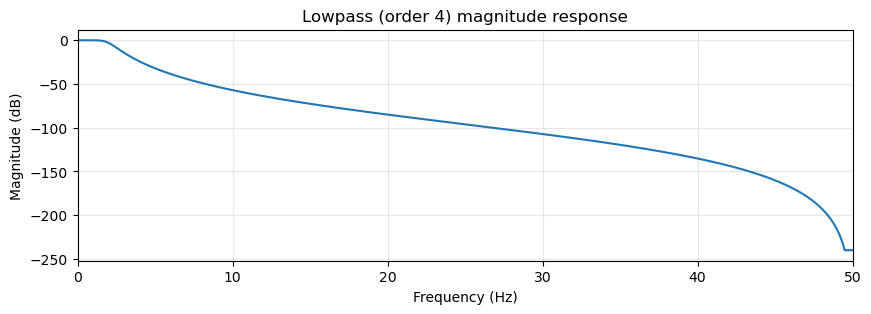

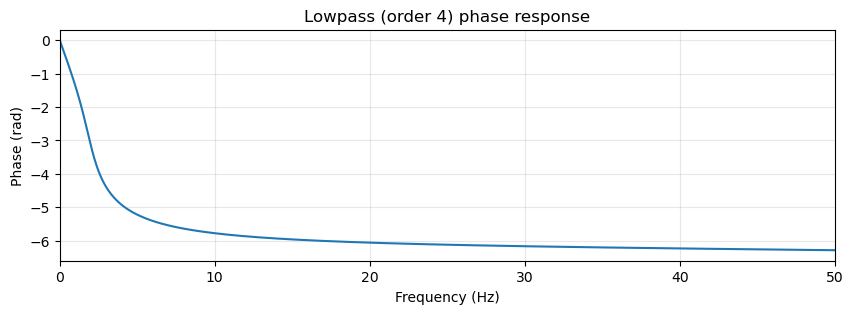

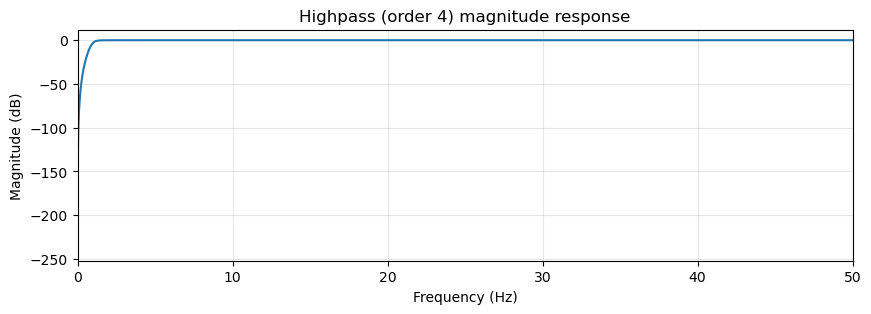

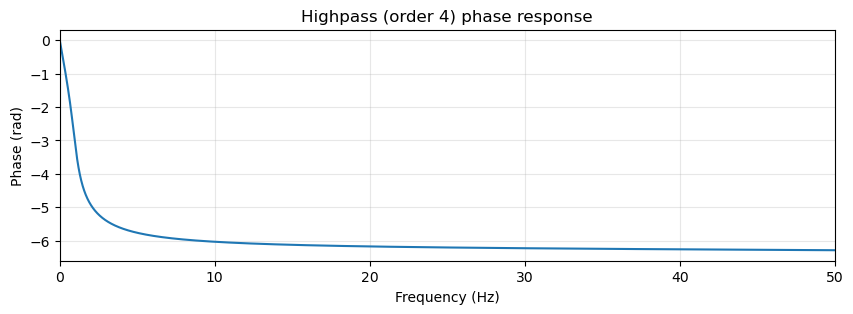

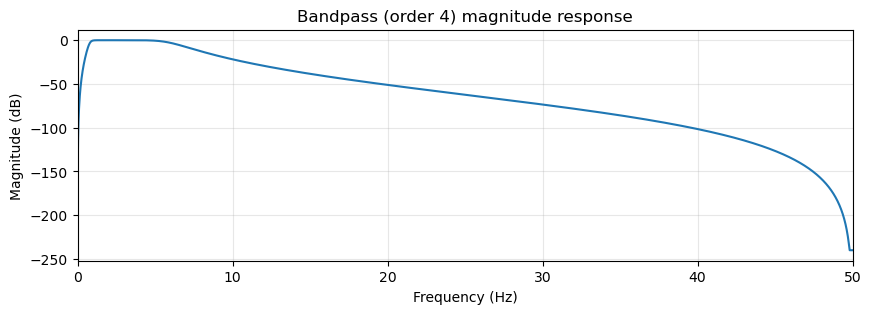

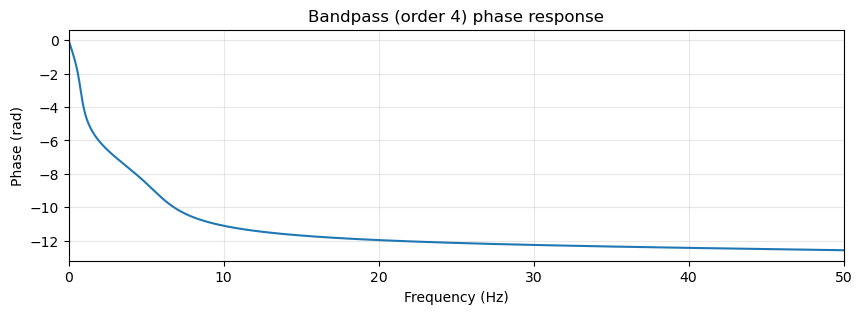

In [3]:

def butter_sos(filter_type, fs, order, f1, f2=None):
    nyq = 0.5 * fs
    if filter_type == "lowpass":
        Wn = f1 / nyq
        return signal.butter(order, Wn, btype="lowpass", output="sos")
    if filter_type == "highpass":
        Wn = f1 / nyq
        return signal.butter(order, Wn, btype="highpass", output="sos")
    if filter_type == "bandpass":
        assert f2 is not None and f2 > f1
        Wn = [f1/nyq, f2/nyq]
        return signal.butter(order, Wn, btype="bandpass", output="sos")
    raise ValueError("Unknown filter_type")

# Example designs
sos_lp = butter_sos("lowpass", fs=fs, order=4, f1=2.0)          # LP below 2 Hz
sos_hp = butter_sos("highpass", fs=fs, order=4, f1=1.0)         # HP above 1 Hz
sos_bp = butter_sos("bandpass", fs=fs, order=4, f1=0.8, f2=6.0) # BP 0.8–6 Hz

plot_freq_response(sos_lp, fs, title="Lowpass (order 4) magnitude response")
plot_phase_response(sos_lp, fs, title="Lowpass (order 4) phase response")

plot_freq_response(sos_hp, fs, title="Highpass (order 4) magnitude response")
plot_phase_response(sos_hp, fs, title="Highpass (order 4) phase response")

plot_freq_response(sos_bp, fs, title="Bandpass (order 4) magnitude response")
plot_phase_response(sos_bp, fs, title="Bandpass (order 4) phase response")


## 6) Apply filters one-way (causal) vs two-way (zero-phase)

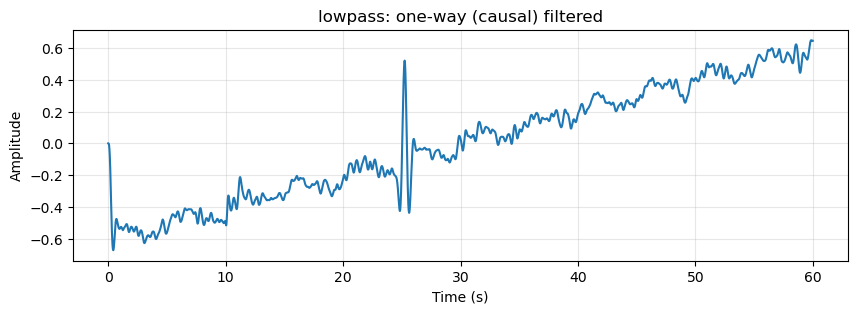

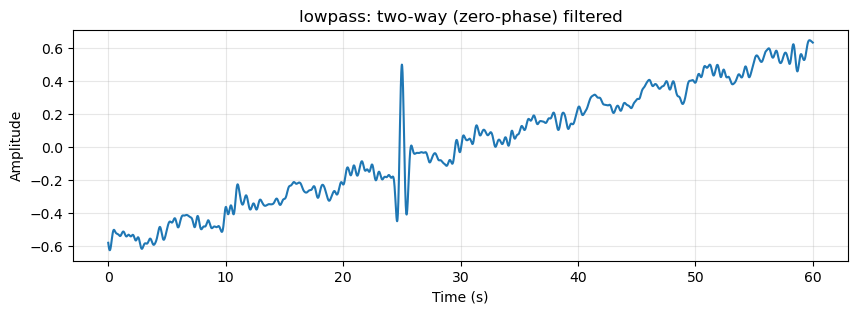

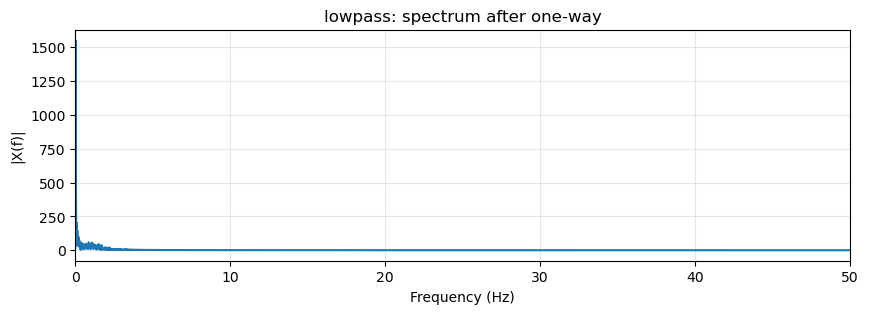

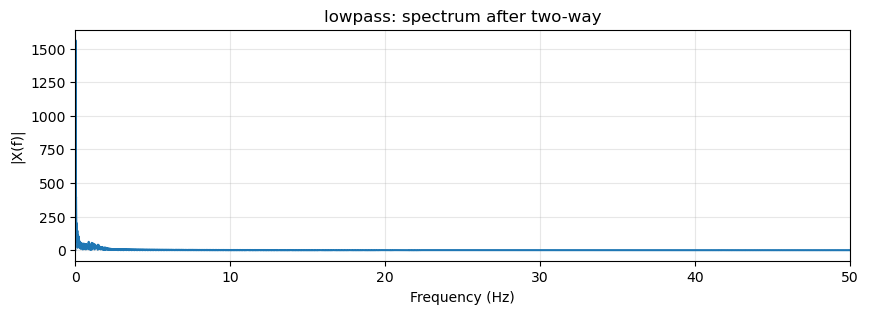

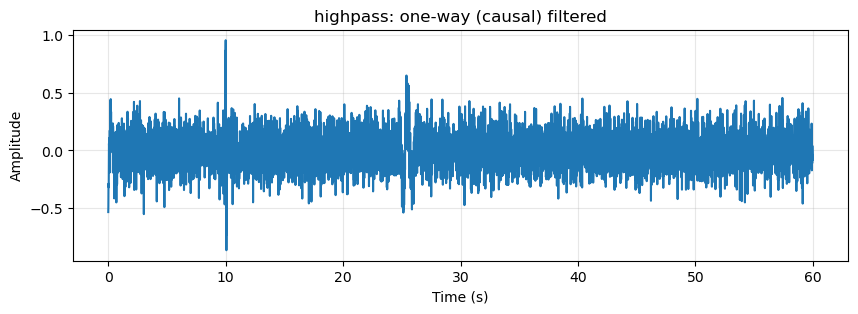

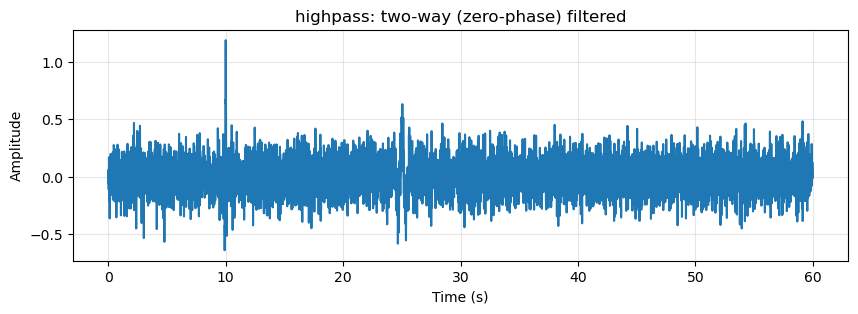

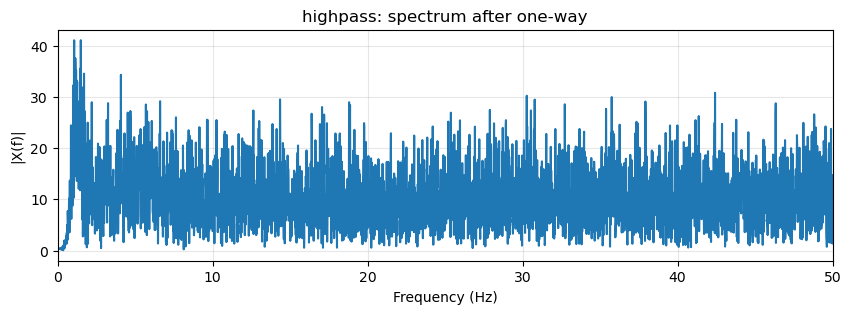

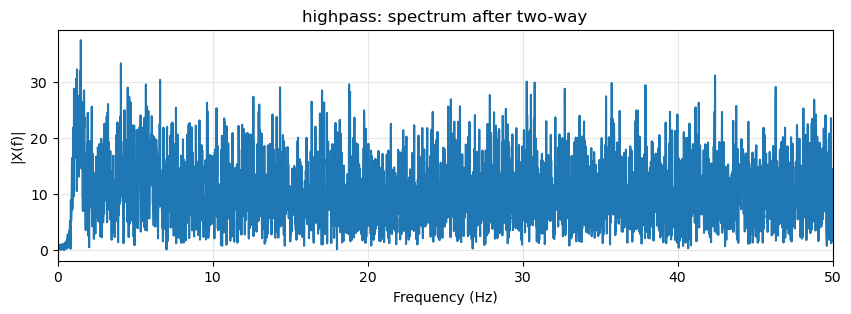

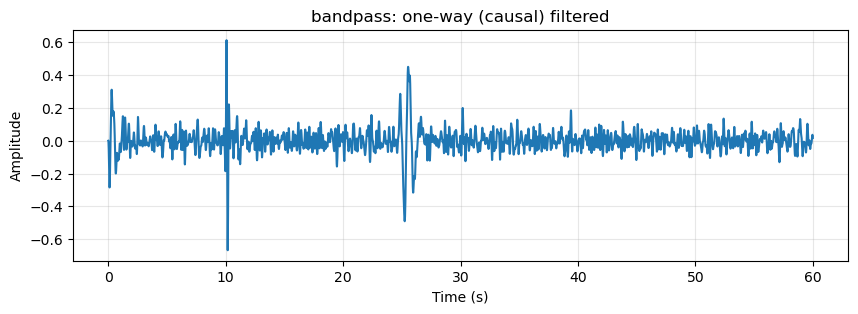

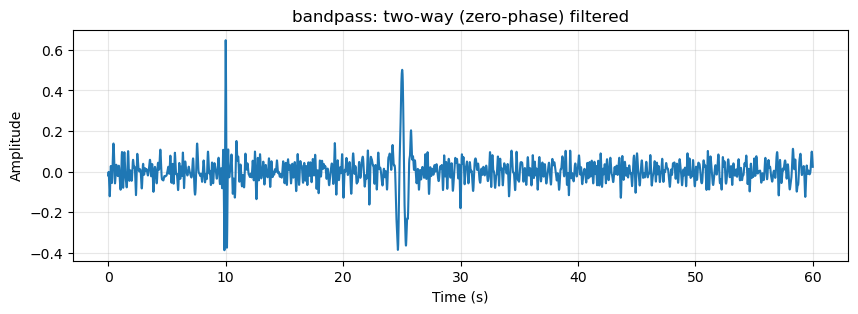

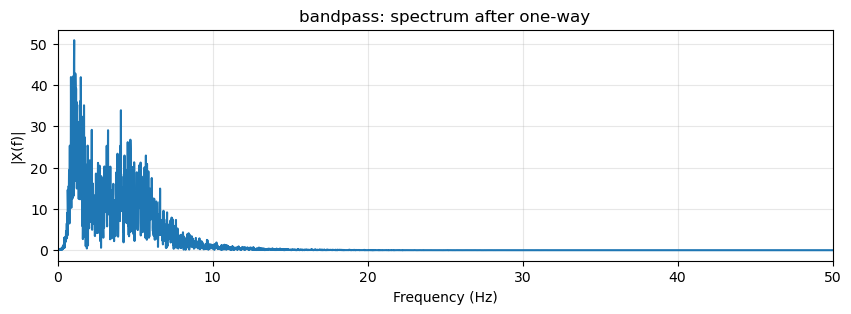

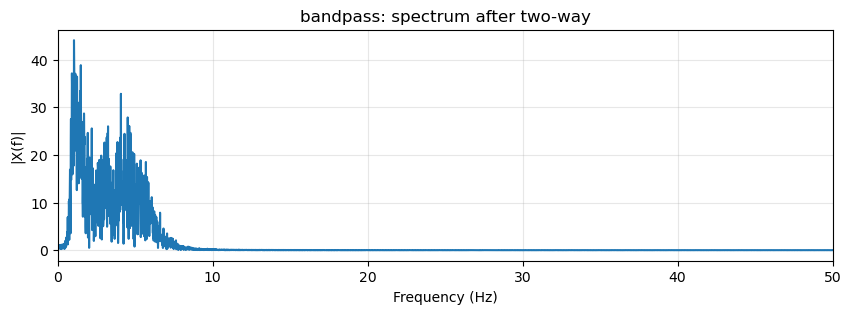

In [4]:

def apply_one_way(sos, x):
    return signal.sosfilt(sos, x)

def apply_two_way(sos, x):
    # Zero-phase forward-backward filtering
    return signal.sosfiltfilt(sos, x)

for name, sos in [("lowpass", sos_lp), ("highpass", sos_hp), ("bandpass", sos_bp)]:
    y1 = apply_one_way(sos, x)
    y2 = apply_two_way(sos, x)

    plot_time(t, y1, title=f"{name}: one-way (causal) filtered")
    plot_time(t, y2, title=f"{name}: two-way (zero-phase) filtered")

    plot_spectrum(y1, fs, title=f"{name}: spectrum after one-way")
    plot_spectrum(y2, fs, title=f"{name}: spectrum after two-way")



### Discussion prompt (for students)

1. Compare the **timing of the sharp onset** around 10 s.
   - Which method preserves the apparent arrival time best?
2. Compare “ringing” (oscillations) around the sharp features.
   - Which one creates symmetric ringing around the arrival?
3. Look near the edges (start/end of trace).
   - Two-way filtering often has stronger edge transients unless padded.

Takeaway:
- **Two-way filtering preserves arrival times** (zero-phase), but is **acausal**.
- **One-way filtering is causal** but generally introduces **delay/phase distortion**.


## 7) Filter order: sharper cutoff vs more ringing

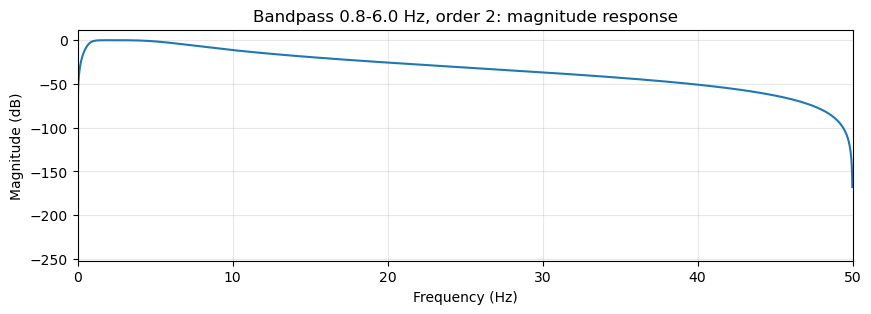

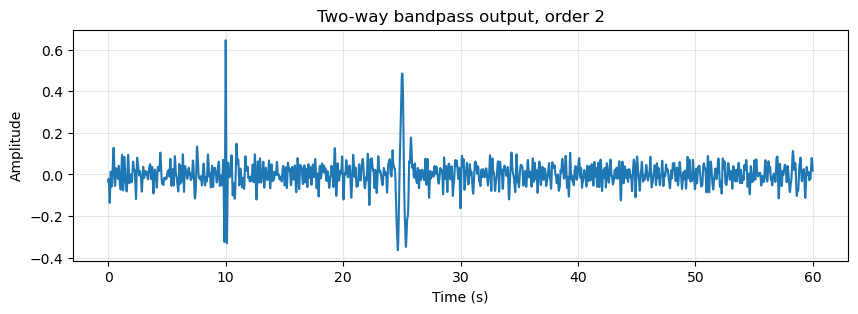

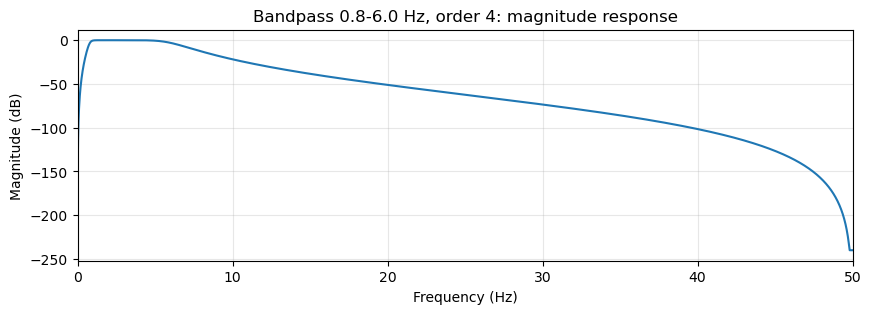

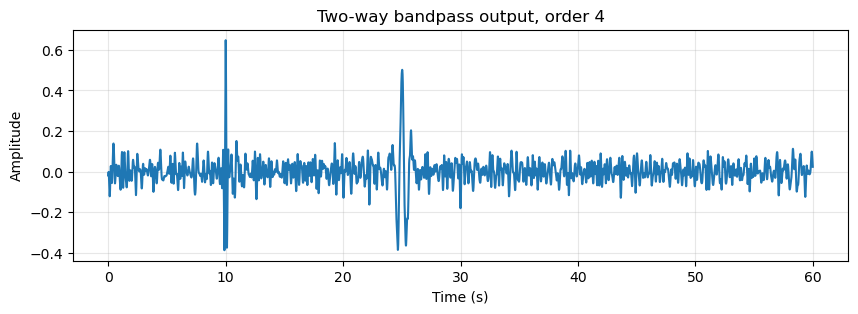

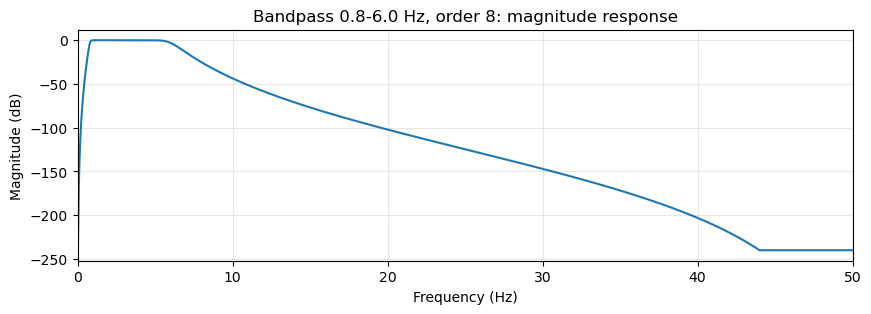

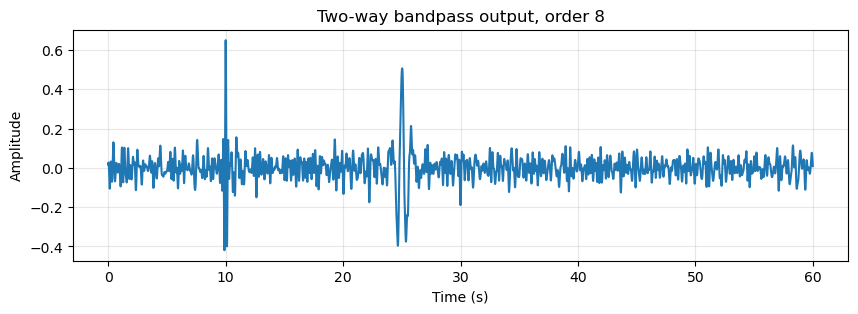

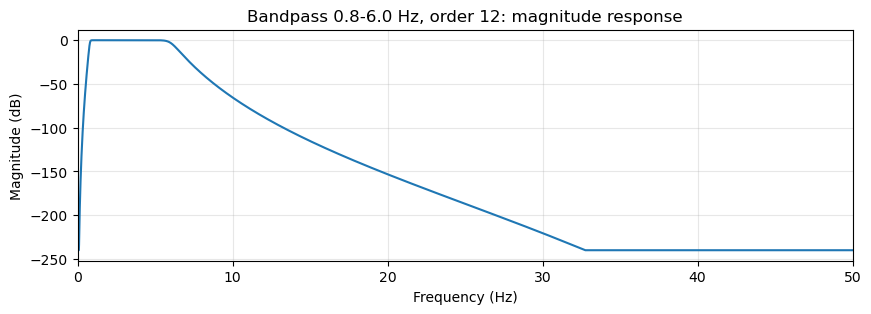

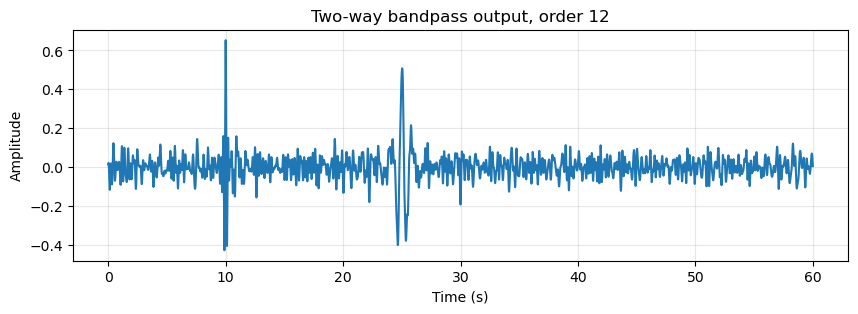

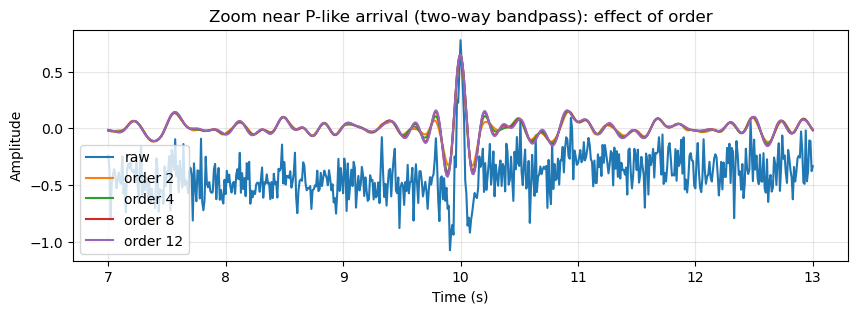

In [5]:

orders = [2, 4, 8, 12]
f1, f2 = 0.8, 6.0  # bandpass band

for order in orders:
    sos = butter_sos("bandpass", fs=fs, order=order, f1=f1, f2=f2)

    plot_freq_response(sos, fs, title=f"Bandpass {f1}-{f2} Hz, order {order}: magnitude response")
    y2 = apply_two_way(sos, x)
    plot_time(t, y2, title=f"Two-way bandpass output, order {order}")

# Optional: zoom into the P-like arrival window to see ringing and timing
t0, t1 = 7, 13
mask = (t >= t0) & (t <= t1)
fig, ax = plt.subplots(figsize=(10,3))
ax.plot(t[mask], x[mask], label="raw")
for order in orders:
    sos = butter_sos("bandpass", fs=fs, order=order, f1=f1, f2=f2)
    y2 = apply_two_way(sos, x)
    ax.plot(t[mask], y2[mask], label=f"order {order}")
ax.set_title("Zoom near P-like arrival (two-way bandpass): effect of order")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Amplitude")
ax.grid(True, alpha=0.3)
ax.legend()
plt.show()



**What to notice:**
- Higher order → **sharper** transition band (better separation)
- Higher order → more **time-domain ringing** and sensitivity to transients
- Two-way filtering doubles the effective order (magnitude response is squared)


## 8) Poles and zeros (digital)

In [ ]:

# Convert an SOS filter to zeros/poles/gain for visualization.
# This is easiest via tf -> zpk, but for numerical stability we keep SOS for filtering.
def sos_to_zpk(sos):
    b, a = signal.sos2tf(sos)
    z, p, k = signal.tf2zpk(b, a)
    return z, p, k

sos = butter_sos("bandpass", fs=fs, order=4, f1=0.8, f2=6.0)
z, p, k = sos_to_zpk(sos)

plot_pz(z, p, title="Bandpass (order 4) pole-zero plot (digital z-plane)")



### Minimum-phase vs zero-phase in pole-zero terms (digital intuition)

- A **minimum-phase** digital filter has all zeros inside the unit circle (stable + causal, minimal delay).
- A **zero-phase** filter is typically achieved by forward-backward filtering, not by a single causal z-plane design.

You can “convert” some FIR magnitude responses into minimum-phase FIRs (spectral factorization),
but forward-backward is the common practical way to get zero-phase for offline seismic processing.


## 9) Demonstrate group delay (why causal filtering shifts things)

In [ ]:

# Group delay: d(phase)/d(omega). SciPy can compute group delay for IIR via (b,a)
def group_delay_from_sos(sos, fs):
    b, a = signal.sos2tf(sos)
    w, gd = signal.group_delay((b, a), fs=fs)
    return w, gd

sos = butter_sos("bandpass", fs=fs, order=4, f1=0.8, f2=6.0)
w, gd = group_delay_from_sos(sos, fs)

fig, ax = plt.subplots(figsize=(10,3))
ax.plot(w, gd)
ax.set_title("Group delay of a causal bandpass filter (order 4)")
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Group delay (samples)")
ax.set_xlim(0, fs/2)
ax.grid(True, alpha=0.3)
plt.show()

print("Note: group delay varies with frequency for IIR filters; arrivals can be smeared/shifted.")



## 10) Practical guidance: which filter when?

### Preserving phase arrival times
- **Two-way (zero-phase)** filtering preserves arrival times *in the filtered trace* (no net phase shift).
- **One-way (causal)** filtering introduces delay/phase distortion; your picks can move.

**Rule of thumb:**
- Offline picking / figures / cross-correlation alignment → **two-way** is often preferred
- Real-time processing / triggering / operational pipelines → **one-way** is required

### Tremor / LP signals
- Often emphasize certain bands (e.g., 0.5–5 Hz, or 1–10 Hz depending on volcano/instruments).
- Bandpass is common, but beware of:
  - filter order too high (ringing)
  - corner too close to dominant frequencies (distortion)

### Removing drift, steps, and instrument offsets
- Highpass at very low corner (e.g., 0.01–0.1 Hz) is common for broadband seismograms.

### Avoiding edge artifacts
- Two-way filtering can create edge transients. Mitigate by:
  - padding/tapering
  - filtering longer windows than you plot, then trimming



## 11) Digital vs analog filters (wrap-up)

### Analog filters (continuous time)
- Described by transfer functions \(H(s)\) with poles/zeros in the **s-plane**
- Implemented with resistors/capacitors/inductors/op-amps
- Always causal

### Digital filters (discrete time)
- Described by \(H(z)\) with poles/zeros in the **z-plane**
- Implemented in software/firmware
- Can be causal (one-way) or acausal (two-way / zero-phase)

### Key differences in practice
- Digital filters depend on **sample rate** (Nyquist limits)
- Forward-backward filtering creates a **non-causal** result and **squares** the magnitude response
- FIR filters can be exactly linear-phase; IIR filters are efficient but typically have nonlinear phase

### Seismology-specific note
Instrument digitizers often use **FIR decimation filters**:
- linear-phase option (often non-causal if implemented as symmetric FIR with delay)
- minimum-phase/causal option (reduced latency for real-time)
